In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict

import mlflow

from copy import deepcopy
from datetime import datetime, timedelta

from configs.base_config import TrainingModuleConfig
from configs.base_config import ModelEvaluatorConfig

from modules.data_fetcher_module import DataFetcherModule
from modules.forecasting_module import ForecastingModule
from configs.base_config import ForecastingModuleConfig
from modules.model_evaluator import ModelEvaluator
from modules.training_module import TrainingModule
from model_wrappers.model_factory import ModelFactory
import model_wrappers.seir

In [4]:
with open('train_config2.json') as f_train, \
    open('test_config.json') as f_test, \
    open('forecast_config.json') as f_forecast, \
    open('plot_config.json') as f_plot:
    default_train_config = json.load(f_train)
    default_test_config = json.load(f_test)
    default_forecast_config = json.load(f_forecast)
    default_plot_config = json.load(f_plot)

In [5]:
default_plot_config

{'colors': {'confirmed': 'C0',
  'deceased': 'red',
  'hospitalized': 'orange',
  'recovered': 'green'},
 'labels': {'confirmed': 'Confirmed Cases',
  'deceased': 'Deceased Cases',
  'hospitalized': 'Hospitalized Cases',
  'recovered': 'Recovered Cases'},
 'markers': {'observed': '-o',
  'predicted': {'max': '--', 'mean': '-.', 'min': '--'},
  'rolling_average': '-'},
 'observed': True,
 'predicted': True,
 'rolling_average': False,
 'uncertainty': False,
 'variables': ['confirmed', 'hospitalized', 'recovered', 'deceased']}

In [6]:
def parse_params(parameters, interval='Train1'):
    """
        Flatten the params dictionary to enable logging
    of the parameters.
    
    Assumptions:
        There is a maximum of one level of nesting.
        Ensured using an assert statement for now.
        
    Sample_input:
        {
            'LatentEbyCRatio': {
                '4/7/20': 0.5648337712691847,
                '4/17/20': 1.1427545912005197
            },
            'LatentIbyCRatio': {
                '4/7/20': 0.9610881623714099,
                '4/17/20': 0.6742970940209254
            }
        }
    
    Output:
        {
            'Train1_LatentEbyCRatio_4/7/20': 0.5648337712691847,
            'Train1_LatentEbyCRatio_4/17/20': 1.1427545912005197,
            'Train1_LatentIbyCRatio_4/7/20': 0.9610881623714099,
            'Train1_LatentIbyCRatio_4/17/20': 0.6742970940209254
        }
    """
    param_dict = dict() # The flattened dictionary to return
    for param in parameters:
        if isinstance(parameters[param], dict):
            for key in parameters[param]:
                assert (not isinstance(parameters[param][key], dict))
                
                param_dict[interval + '_' + param + '_'+ key] = parameters[param][key]
        else:
            param_dict[interval + '_' + param] = parameters[param]
    return param_dict

In [7]:
def train_eval(region, region_type, 
               train1_start_date, train1_end_date, 
               train2_start_date, train2_end_date, run_day,
               test_start_date, test_end_date, max_evals = 1000, 
               data_source = None, mlflow_log = True, name_prefix = None):
    """
        #TODO: Need to add hooks to consume data from appropriate source

        Run train and evalation for (basic) SEIR model.
    
    Arguments:
        region, region_type : Region info corresponding to the run
        train1_start_date, train1_end_date : Train1 durations
        train2_start_date, train2_end_date : Train2 durations
        test_start_date, test_end_date, run_day : Test durations
        max_evals : number of search evaluations for SEIR (default: 1000)
        data_source : Data source for picking the region data
        mlflow_log : Experiment logged using MLFlow (default: True)
        name_prefix : In case of non-MLFlow experiment, string prefix to
                      enable easy indexing of experiments

    Note:
        date_format : %-m/%-d/%-y

    Returns: 
        params : Run parameters to be logged
        metrics : Metrics collected from the run 
    
    Output files saved : (name_prefix added in the case of non-MLflow experiments)
        Train1 : train1_output.json (name_prefix + '_train1_output.json')
        Train2 : train2_output.json (name_prefix + '_train2_output.json')
        Test   : test_output.json   (name_prefix + '_test_output.json')
    """
    
    # Save metrics and params for logging
    params = dict()
    metrics = dict()

    params['region'] = region
    params['region_type'] = region_type
    params['train1_start_date'] = train1_start_date
    params['train1_end_date'] = train1_end_date
    params['train2_start_date'] = train2_start_date
    params['train2_end_date'] = train2_end_date
    params['run_day'] = run_day
    params['test_start_date'] = test_start_date
    params['test_end_date'] = test_end_date
    params['data_source'] = data_source
    
    # model parameters
    model_params = dict()
    model_params['region'] = region
    model_params['region_type'] = region_type
    model_params['model_type'] = "SEIR"
    
    # train1 model parameters
    train1_model_params = deepcopy(model_params)

    train_config = deepcopy(default_train_config)
    train_config['region_name'] = region
    train_config['region_type'] = region_type
    train_config['train_start_date'] = train1_start_date
    train_config['train_end_date'] = train1_end_date
    train_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        train_config['output_filepath'] = 'train1_output.json'
    else:
        assert name_prefix is not None
        train_config['output_filepath'] = name_prefix + '_train1_output.json'

    train_module_config = TrainingModuleConfig.parse_obj(train_config)
    trainResults = TrainingModule.from_config(train_module_config)
    
    train1_model_params['model_parameters'] = dict()
    train1_model_params['model_parameters'].update(trainResults['best_params'])
    train1_model_params['model_parameters'].update(trainResults['latent_params'])
    train1_model_params['model_parameters']['MAPE'] = trainResults['train_metric_results'][0]['value']
    
    metrics['Train1MAPE'] = trainResults['train_metric_results'][0]['value']
    metrics['Train1RMLSE'] = trainResults['train_metric_results'][1]['value']
    metrics.update(parse_params(trainResults['best_params'], 'Train1')) 
    
    test_config = deepcopy(default_test_config)
    test_config['region_name'] = region
    test_config['region_type'] = region_type
    test_config['test_start_date'] = test_start_date
    test_config['test_end_date'] = test_end_date
    test_config['run_day'] = run_day
    test_config['model_parameters'].update(trainResults['best_params'])    
    test_config['model_parameters'].update(trainResults['latent_params'])  
        
    if mlflow_log:
        test_config['output_filepath'] = 'test_output.json'
    else:
        test_config['output_filepath'] = name_prefix + '_test_output.json'

    test_module_config = ModelEvaluatorConfig.parse_obj(test_config) 
    evalResults = ModelEvaluator.from_config(test_module_config)
    
    metrics['TestMAPE'] = evalResults[0]['value']
    metrics['TestRMLSE'] = evalResults[1]['value']
    
    
    finalTrain_config = deepcopy(default_train_config)
    finalTrain_config['region_name'] = region
    finalTrain_config['region_type'] = region_type
    finalTrain_config['train_start_date'] = train2_start_date
    finalTrain_config['train_end_date'] = train2_end_date
    finalTrain_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        finalTrain_config['output_filepath'] = 'train2_output.json'
    else:
        finalTrain_config['output_filepath'] = name_prefix + '_train2_output.json'

    finalTrain_module_config = TrainingModuleConfig.parse_obj(finalTrain_config)
    finalResults = TrainingModule.from_config(finalTrain_module_config)
    
    metrics['Train2MAPE'] = finalResults['train_metric_results'][0]['value']
    metrics['Train2RMLSE'] = finalResults['train_metric_results'][1]['value']
    metrics.update(parse_params(finalResults['best_params'], 'Train2'))
        
    model_params['model_parameters'] = dict()
    model_params['model_parameters'].update(finalResults['best_params'])
    model_params['model_parameters'].update(finalResults['latent_params'])
    model_params['model_parameters']['MAPE'] = finalResults['train_metric_results'][0]['value']
    
    return params, metrics, model_params, train1_model_params

In [8]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '4/28/20'
train1_end_date = '5/4/20'
train2_start_date = '5/5/20'
train2_end_date = '5/11/20'
test_start_date = '5/5/20'
test_end_date = '5/11/20'
run_day = '5/4/20'

params, metrics, model_params, train1_model_params = train_eval(region, region_type, 
                                                                train1_start_date, train1_end_date, 
                                                                train2_start_date, train2_end_date, run_day,
                                                                test_start_date, test_end_date,
                                                                max_evals = 100,
                                                                mlflow_log = False,
                                                                name_prefix = 'mumbai_sample')

t = 7.90                                               
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                         
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                         
t = 7.90                                           

100%|██████████| 100/100 [00:08<00:00, 11.88trial/s, best loss: 6.299770676082446]
Best fit: {'EbyCRatio': 0.7812341043805002, 'IbyCRatio': 0.3543860616922349, 'infectious_period': 8.85642464946022, 'r0': 1.6451175464534868}
Best Loss: 6.299770676082446
t = 7.90
t = 7.90
t = 7.90
t = 7.90                                               
t = 7.90                                               
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                       
t = 7.90                                                                       
t = 7.90                                                                       
t = 7.90                                                                       
t = 7.90                                    

t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
100%|██████████| 100/100 [00:08<00:00, 12.31trial/s, best loss: 10.24741694119463]
Best fit: {'EbyCRatio': 0.22298880140452668, 'IbyCRatio': 0.9571745673174378, 'infectious_period': 3.6263827369990347, 'r0': 0.5182012049792062}
Best Loss: 10.24741694119463
t = 7.90
t = 7.90


In [9]:
params

{'data_source': None,
 'region': 'mumbai',
 'region_type': 'district',
 'run_day': '5/4/20',
 'test_end_date': '5/11/20',
 'test_start_date': '5/5/20',
 'train1_end_date': '5/4/20',
 'train1_start_date': '4/28/20',
 'train2_end_date': '5/11/20',
 'train2_start_date': '5/5/20'}

In [10]:
metrics

{'TestMAPE': 12.29786857452032,
 'TestRMLSE': 0.14929727681393934,
 'Train1MAPE': 6.299770676082446,
 'Train1RMLSE': 0.06577451714631943,
 'Train1_EbyCRatio': 0.7812341043805002,
 'Train1_IbyCRatio': 0.3543860616922349,
 'Train1_infectious_period': 8.85642464946022,
 'Train1_r0': 1.6451175464534868,
 'Train2MAPE': 10.24741694119463,
 'Train2RMLSE': 0.11581098667879622,
 'Train2_EbyCRatio': 0.22298880140452668,
 'Train2_IbyCRatio': 0.9571745673174378,
 'Train2_infectious_period': 3.6263827369990347,
 'Train2_r0': 0.5182012049792062}

In [11]:
model_params

{'model_parameters': {'EbyCRatio': 0.22298880140452668,
  'IbyCRatio': 0.9571745673174378,
  'LatentEbyCRatio': {'5/11/20': 0.1726139900461888,
   '5/4/20': 0.22298880140452668},
  'LatentIbyCRatio': {'5/11/20': 0.21996544713918792,
   '5/4/20': 0.9571745673174378},
  'MAPE': 10.24741694119463,
  'infectious_period': 3.6263827369990347,
  'r0': 0.5182012049792062},
 'model_type': 'SEIR',
 'region': 'mumbai',
 'region_type': 'district'}

In [12]:
model_params['model_parameters']['incubation_period'] = 5

In [13]:
model_params

{'model_parameters': {'EbyCRatio': 0.22298880140452668,
  'IbyCRatio': 0.9571745673174378,
  'LatentEbyCRatio': {'5/11/20': 0.1726139900461888,
   '5/4/20': 0.22298880140452668},
  'LatentIbyCRatio': {'5/11/20': 0.21996544713918792,
   '5/4/20': 0.9571745673174378},
  'MAPE': 10.24741694119463,
  'incubation_period': 5,
  'infectious_period': 3.6263827369990347,
  'r0': 0.5182012049792062},
 'model_type': 'SEIR',
 'region': 'mumbai',
 'region_type': 'district'}

In [14]:
train1_model_params['model_parameters']['incubation_period'] = 5

In [15]:
train1_model_params

{'model_parameters': {'EbyCRatio': 0.7812341043805002,
  'IbyCRatio': 0.3543860616922349,
  'LatentEbyCRatio': {'4/27/20': 0.7812341043805002,
   '5/4/20': 0.5134357243344126},
  'LatentIbyCRatio': {'4/27/20': 0.3543860616922349,
   '5/4/20': 0.4651427433114956},
  'MAPE': 6.299770676082446,
  'incubation_period': 5,
  'infectious_period': 8.85642464946022,
  'r0': 1.6451175464534868},
 'model_type': 'SEIR',
 'region': 'mumbai',
 'region_type': 'district'}

In [16]:
def forecast(model_params, run_day, forecast_start_date, forecast_end_date):
    evalConfig = ForecastingModuleConfig.parse_obj(default_forecast_config)
    evalConfig.region_name = model_params['region']
    evalConfig.region_type = model_params['region_type']
    evalConfig.model_parameters = model_params['model_parameters']

    evalConfig.run_day = run_day
    evalConfig.forecast_start_date = forecast_start_date
    evalConfig.forecast_end_date = forecast_end_date
    
    forecast_json = ForecastingModule.from_config(evalConfig)
    forecast_df = pd.read_json(forecast_json)
    forecast_df = forecast_df.drop(columns=['Region Type', 'Region', 'Country', 'Lat', 'Long'])
    forecast_df = forecast_df.set_index('prediction_type')
    forecast_df = forecast_df.transpose().reset_index()
    return forecast_df

In [17]:
run_day = '5/4/20'
forecast_start_date = '5/5/20'
forecast_end_date = '5/11/20'
forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)

t = 7.90


/Users/nayana/.local/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [18]:
forecast_df

prediction_type,index,exposed,active_mean,recovered_mean,deceased_mean,confirmed_mean,hospitalized_mean,active_min,active_max,hospitalized_min,hospitalized_max,recovered_min,recovered_max,deceased_min,deceased_max,confirmed_min,confirmed_max
0,5/10/20,1780.957494,2406.567111,6742.852591,179.994012,9329.413714,625.707449,2159.956145,2653.178077,561.588598,689.826300,6051.884373,7433.820810,161.549275,198.438749,8373.389792,10285.437635
1,5/11/20,1669.989800,2128.101280,7350.394099,196.211752,9674.707131,553.306333,1910.025869,2346.176691,496.606726,610.005940,6597.168569,8103.619629,176.105116,216.318388,8683.299554,10666.114709
2,5/5/20,1853.311588,5425.734446,1919.755182,51.246032,7396.735659,1410.690956,4869.736815,5981.732077,1266.131572,1555.250340,1723.029864,2116.480499,45.994637,56.497426,6638.761316,8154.710002
3,5/6/20,1978.466212,4453.422629,3241.431283,86.526913,7781.380825,1157.889884,3997.061844,4909.783414,1039.236079,1276.543688,2909.268305,3573.594262,77.660140,95.393687,6983.990288,8578.771362
4,5/7/20,2000.496611,3730.577859,4334.780588,115.712829,8181.071276,969.950243,3348.289991,4112.865726,870.555398,1069.345089,3890.577548,4778.983629,103.855253,127.570405,7342.722792,9019.419760
5,5/8/20,1959.972032,3178.662472,5259.044921,140.385183,8578.092575,826.452243,2852.931675,3504.393268,741.762235,911.142250,4720.128660,5797.961181,125.999328,154.771038,7699.059663,9457.125486
6,5/9/20,1881.882382,2747.683877,6053.234815,161.585324,8962.504016,714.397808,2466.117253,3029.250500,641.190486,787.605130,5432.934606,6673.535025,145.027002,178.143645,8044.078861,9880.929170


In [19]:
def get_observations_in_range(region_name, region_type, 
                              start_date, end_date,
                              obs_type = 'confirmed'):
    """
        Return a list of counts of obs_type cases
        from the region in the specified date range.
    """
    observations = DataFetcherModule.get_observations_for_region(region_type, region_name)
    observations_df = observations[observations['observation'] == obs_type]
    
    start_date = datetime.strptime(start_date, '%m/%d/%y')
    end_date = datetime.strptime(end_date, '%m/%d/%y')
    delta = (end_date - start_date).days
    days = []
    for i in range(delta + 1):
        days.append((start_date + timedelta(days=i)).strftime('%-m/%-d/%-y'))
    
    # Fetch observations in the date range
    observations_df = observations_df[days]
    
    # Transpose the df to get the
    # observations_df.shape = (num_days, 1)
    observations_df = observations_df.reset_index(drop=True).transpose()
    
    # Rename the column to capture observation type
    # Note that the hardcoded 0 in the rename comes from the reset_index
    # from the previous step
    observations = observations_df[0].to_list()
    return observations

In [20]:
observations = get_observations_in_range('mumbai', 'district', '5/5/20', '5/11/20')

In [21]:
forecast_df['actual_confirmed'] = observations

In [22]:
forecast_df

prediction_type,index,exposed,active_mean,recovered_mean,deceased_mean,confirmed_mean,hospitalized_mean,active_min,active_max,hospitalized_min,hospitalized_max,recovered_min,recovered_max,deceased_min,deceased_max,confirmed_min,confirmed_max,actual_confirmed
0,5/10/20,1780.957494,2406.567111,6742.852591,179.994012,9329.413714,625.707449,2159.956145,2653.178077,561.588598,689.826300,6051.884373,7433.820810,161.549275,198.438749,8373.389792,10285.437635,7687.0
1,5/11/20,1669.989800,2128.101280,7350.394099,196.211752,9674.707131,553.306333,1910.025869,2346.176691,496.606726,610.005940,6597.168569,8103.619629,176.105116,216.318388,8683.299554,10666.114709,8456.0
2,5/5/20,1853.311588,5425.734446,1919.755182,51.246032,7396.735659,1410.690956,4869.736815,5981.732077,1266.131572,1555.250340,1723.029864,2116.480499,45.994637,56.497426,6638.761316,8154.710002,9136.0
3,5/6/20,1978.466212,4453.422629,3241.431283,86.526913,7781.380825,1157.889884,3997.061844,4909.783414,1039.236079,1276.543688,2909.268305,3573.594262,77.660140,95.393687,6983.990288,8578.771362,9884.0
4,5/7/20,2000.496611,3730.577859,4334.780588,115.712829,8181.071276,969.950243,3348.289991,4112.865726,870.555398,1069.345089,3890.577548,4778.983629,103.855253,127.570405,7342.722792,9019.419760,10606.0
5,5/8/20,1959.972032,3178.662472,5259.044921,140.385183,8578.092575,826.452243,2852.931675,3504.393268,741.762235,911.142250,4720.128660,5797.961181,125.999328,154.771038,7699.059663,9457.125486,10606.0
6,5/9/20,1881.882382,2747.683877,6053.234815,161.585324,8962.504016,714.397808,2466.117253,3029.250500,641.190486,787.605130,5432.934606,6673.535025,145.027002,178.143645,8044.078861,9880.929170,10606.0


In [31]:
def plot(model_params, run_day, forecast_start_date, forecast_end_date, 
         actual_start_date, plot_name = 'default.png'):
 
    forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)
    forecast_df['index'] = pd.to_datetime(forecast_df['index'])
    forecast_df = forecast_df.sort_values(by=['index'])

    actual = DataFetcherModule.get_observations_for_region(model_params['region_type'], model_params['region'])
    actual = actual.set_index('observation')
    actual = actual.transpose()
    actual = actual.reset_index()
    start = actual.index[actual['index'] == actual_start_date].tolist()[0]
    actual = actual[start : ]
    actual['index'] = pd.to_datetime(actual['index'])
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title(model_params['region'])
    ax.plot(actual['index'], actual['confirmed'], color='green', label="observed")
    ax.plot(forecast_df['index'], forecast_df['confirmed_mean'], color='orange', label="predicted")
    plt.xticks(rotation=90)
    ax.set_ylim(ymin=0)
    ax.legend()
    fig.tight_layout()
    
    plt.savefig(plot_name)

t = 24.90


/Users/nayana/.local/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


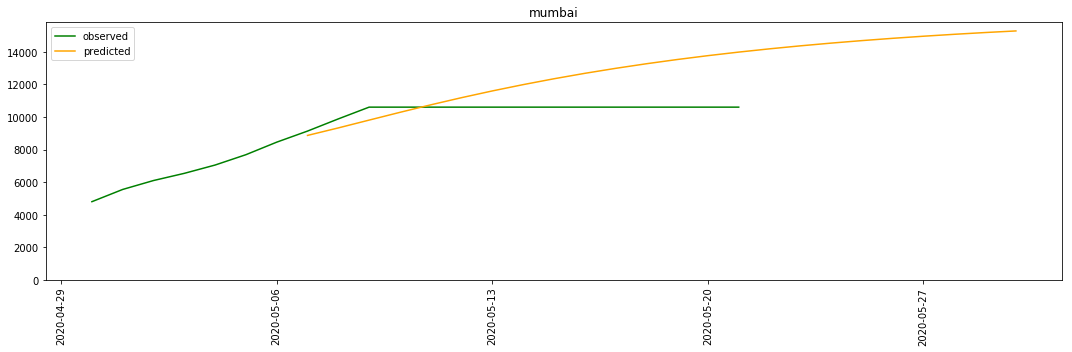

In [32]:
run_day = '5/6/20'
forecast_start_date = '5/7/20'
forecast_end_date = '5/30/20'
actual_start_date = '4/30/20' 

%matplotlib inline
plot(model_params, run_day, forecast_start_date, forecast_end_date, actual_start_date)

In [35]:
def plot_m1(train_start_date, train_end_date, test_run_day, test_start_date, test_end_date, 
            rolling_average = False, uncertainty = False, plot_name = 'default.png'):
    
    ## TODO: Log scale
    
    plot_config = deepcopy(default_plot_config)
    plot_config['uncertainty'] = uncertainty
    plot_config['rolling_average'] = rolling_average
    
    actual_start_date = (datetime.strptime(train_start_date, "%m/%d/%y") - timedelta(days=7)).strftime("%-m/%-d/%y")    
    train_run_day = (datetime.strptime(train_start_date, "%m/%d/%y") - timedelta(days=1)).strftime("%-m/%-d/%y")
    
    # Get predictions
    pd_df_train = forecast(train1_model_params, train_run_day, train_start_date, train_end_date)
    pd_df_test = forecast(train1_model_params, test_run_day, test_start_date, test_end_date)
    
    pd_df_train['index'] = pd.to_datetime(pd_df_train['index'])
    pd_df_test['index'] = pd.to_datetime(pd_df_test['index']) 
    pd_df = pd.concat([pd_df_train, pd_df_test])
    pd_df = pd_df.sort_values(by=['index'])

    # Get observed data
    actual = DataFetcherModule.get_observations_for_region(model_params['region_type'], model_params['region'])
    actual = actual.set_index('observation')
    actual = actual.transpose()
    actual = actual.reset_index()
    start = actual.index[actual['index'] == actual_start_date].tolist()[0]
    end = actual.index[actual['index'] == test_end_date].tolist()[0]
    actual = actual[start : end+1]
    actual['index'] = pd.to_datetime(actual['index'])
    
    plot_markers = plot_config['markers']
    plot_colors = plot_config['colors']
    plot_labels = plot_config['labels']
    plot_variables = plot_config['variables']
    
    fig, ax = plt.subplots(figsize=(16, 12))
    
    for variable in plot_variables:
        
        # Plot observed values
        ax.plot(actual['index'], actual[variable], plot_markers['observed'], 
                color = plot_colors[variable], label = plot_labels[variable]+': Observed')
        
        # Plot mean predictions
        if variable+'_mean' in pd_df:
            ax.plot(pd_df['index'], pd_df[variable+'_mean'], plot_markers['predicted']['mean'], 
                    color = plot_colors[variable], label = plot_labels[variable]+': Predicted')
        
        # Plot uncertainty in predictions
        if plot_config['uncertainty'] == True:
            
            if variable+'_min' in pd_df:
                ax.plot(pd_df['index'], pd_df[variable+'_min'], plot_markers['predicted']['min'], 
                    color = plot_colors[variable], label = plot_labels[variable]+': Predicted (Min)')
                
            if variable+'_max' in pd_df:
                ax.plot(pd_df['index'], pd_df[variable+'_max'], plot_markers['predicted']['max'], 
                    color = plot_colors[variable], label = plot_labels[variable]+': Predicted (Max)')
        
        # Plot rolling average
        if plot_config['rolling_average'] == True and variable+'_ra' in pd_df: 
            ax.plot(pd_df['index'], pd_df[variable+'_ra'], plot_markers['rolling_average'], 
                color = plot_colors[variable], label = plot_labels[variable]+': Predicted (RA)')
    
    train_start = pd.to_datetime(train1_start_date)
    test_start = pd.to_datetime(test_start_date)
    
    line_height = plt.ylim()[1]
    ax.plot([train_start, train_start], [0,line_height], '--', color='brown', label='Train starts')
    ax.plot([test_start, test_start], [0,line_height], '--', color='black', label='Test starts')
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    plt.ylabel('No of People')
    plt.xlabel('Time')
    plt.legend()
    plt.grid()
    
    plt.savefig(plot_name)

t = 7.90


/Users/nayana/.local/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


t = 7.90


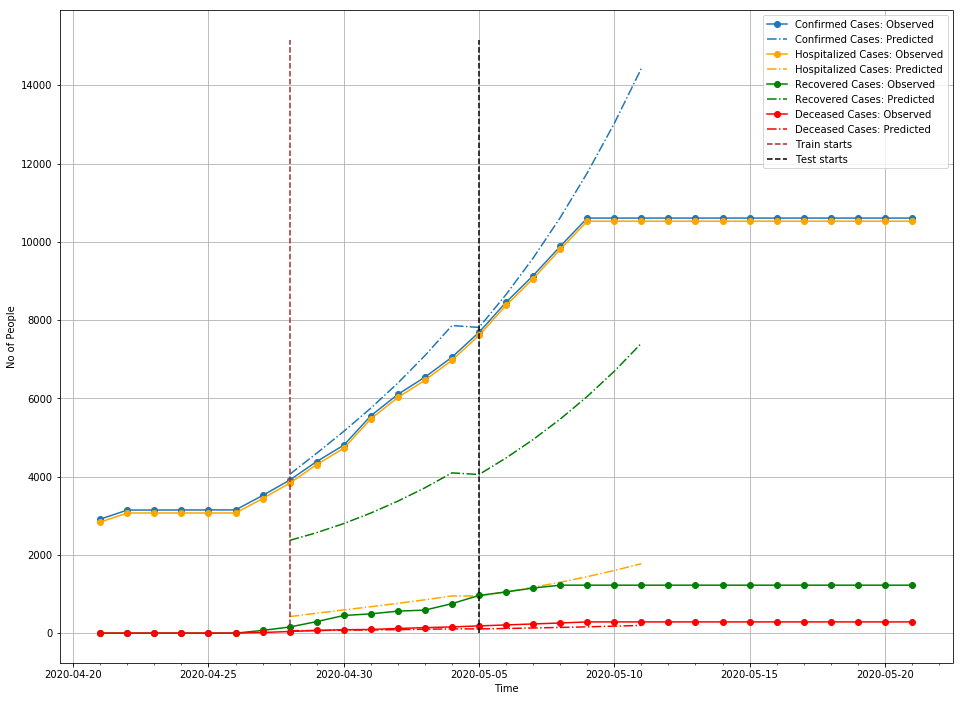

In [36]:
rolling_average = False
uncertainty = False

test_run_day = '5/4/20'

%matplotlib inline
plot_m1(train1_start_date, train1_end_date, test_run_day, test_start_date, test_end_date,
        rolling_average = rolling_average, uncertainty = uncertainty, plot_name = "default.png")

In [25]:
def train_eval_forecast(region, region_type, 
                        train1_start_date, train1_end_date, 
                        train2_start_date, train2_end_date,
                        test_run_day, test_start_date, test_end_date, 
                        forecast_run_day, forecast_start_date, forecast_end_date,
                        max_evals = 1000, 
                        data_source = None, mlflow_log = True, name_prefix = None,
                        plot_actual_vs_predicted = False, plot_name = 'default.png'):
    """
        Run train, evaluation and generate forecasts as a dataframe.
        
        If plot_actual_vs_predicted is set to True,
        we first check if the forecast_end_date is prior to the current date
        so that we have actual_confirmed cases and then plot the predictions.
    """
    params, metrics, model_params = train_eval(region, region_type, 
                                               train1_start_date, train1_end_date, 
                                               train2_start_date, train2_end_date, 
                                               test_run_day, test_start_date, test_end_date, 
                                               max_evals, data_source, 
                                               mlflow_log, name_prefix)
    model_params['model_parameters']['incubation_period'] = 5
    forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)
    
    plot(model_params, forecast_run_day, forecast_start_date, 
         forecast_end_date, actual_start_date=train1_start_date, plot_name=plot_name)
    
    return forecast_df, params, metrics, model_params

In [26]:
def dates_to_str(dates):
    str_dates = dict()
    for date in dates:
        str_dates[date] = dates[date].strftime("%-m/%-d/%y")
    return str_dates

In [27]:
def set_dates(train2_end_date, forecast_end_date):
    t = datetime.now().date()

    dates = defaultdict()

    dates["train1_start_date"] = (t - timedelta(14))
    dates["train1_end_date"] = (t - timedelta(8))

    if train2_end_date is None:
        dates["train2_start_date"] = (t - timedelta(7))
        dates["train2_end_date"] = (t - timedelta(1))
    else:
        dates["train2_end_date"] = datetime.strptime(train2_end_date, "%m/%d/%y")
        dates["train2_start_date"] = dates["train2_end_date"] - timedelta(6)

    dates["test_start_date"] = dates['train2_start_date']
    dates["test_end_date"] = dates['train2_end_date']
    dates["test_run_day"] = dates["test_start_date"] - timedelta(1)

    dates["forecast_start_date"] = dates["test_start_date"]
    dates["forecast_run_day"] = dates["forecast_start_date"] - timedelta(1)
    dates["forecast_end_date"] = datetime.strptime(forecast_end_date, "%m/%d/%y")

    dates = dates_to_str(dates)
    print(dates)

    return dates

In [ ]:
mlflow.set_tracking_uri("http://ec2-54-175-207-176.compute-1.amazonaws.com")
mlflow.set_experiment("seir_trial")

In [ ]:
trials = [{'region':'mumbai','region_type':'district','forecast_end_date':'5/20/20'},
          {'region':'bengaluru urban','region_type':'district','forecast_end_date':'5/20/20'}]

for trial in trials:
    region = trial['region']
    region_type = trial['region_type']
    forecast_end_date = trial['forecast_end_date']
    name_prefix = "{}_{}_{}".format(region, region_type, datetime.now())
    plot_name = '{}_{}_{}.png'.format(region, forecast_end_date.replace('/', '-'), datetime.now())
    
    dates = set_dates(None, forecast_end_date)

    with mlflow.start_run():
        forecast_df, params, metrics, model_params = train_eval_forecast(region, region_type, 
                                                                         dates['train1_start_date'], dates['train1_end_date'], 
                                                                         dates['train2_start_date'], dates['train2_end_date'],
                                                                         dates['test_run_day'], dates['test_start_date'], dates['test_end_date'], 
                                                                         dates['forecast_run_day'], dates['forecast_start_date'], dates["forecast_end_date"],
                                                                         max_evals = 100, 
                                                                         mlflow_log = True, name_prefix = name_prefix,
                                                                         plot_actual_vs_predicted = 'True', 
                                                                         plot_name = plot_name)

        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.log_artifact(plot_name)
        mlflow.log_artifact('train_config.json')
        mlflow.log_artifact('train1_output.json')
        mlflow.log_artifact('test_output.json')
        mlflow.log_artifact('train2_output.json')